In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json

In [2]:
# Name of the CSV file and read

obesity_df = pd.read_csv('Resources/500_Cities__Obesity_among_adults_aged___18_years_20231109.csv', encoding= 'ISO-8859-1')
income_df = pd.read_csv('Resources/kaggle_income.csv', encoding='ISO-8859-1')
weather_df = pd.read_csv('Resources/56_Major_City_Weather_Data.csv', encoding='ISO-8859-1')

In [3]:
# review weather df
weather_df.head(2)

,ï»¿Metropolitan Area,2020 Population,City,Avg_High_Temp_F,Avg_Low_Temp_F,Avg_High_Temp_C,Avg_Low_Temp_C,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,"Atlanta-Sandy Springs-Alpharetta, GA","6,089,815","Atlanta, Georgia",73,54,23,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Austin-Round Rock-Georgetown, TX","2,283,371","Austin, Texas",81,59,27,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# review income df
income_df.head(2)

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685


In [5]:
# review obesity df
obesity_df.head(2)

,ï»¿Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,CA,California,Hayward,City,BRFSS,Unhealthy Behaviors,633000,Obesity among adults aged >=18 Years,%,...,24.4,NaN,NaN,"144,186","(37.6329591551, -122.077051051)",UNHBEH,OBESITY,633000.0,NaN,Obesity
1,2017,CA,California,Lakewood,City,BRFSS,Unhealthy Behaviors,639892,Obesity among adults aged >=18 Years,%,...,22.2,NaN,NaN,"80,048","(33.8470531941, -118.122204765)",UNHBEH,OBESITY,639892.0,NaN,Obesity


In [6]:
#cleaning and grouping of income by city name
cleaned_income_df = income_df.drop(['id', 'Type', 'Primary', 
                                     'Area_Code','ALand','AWater',
                                     'Lat','Lon','sum_w'], axis=1)
city_income_df = cleaned_income_df.groupby('City', as_index = False)['Mean'].mean()
city_income_df.head()

,City,Mean
0,Abbeville,38459.428571
1,Abbotsford,58254.000000
2,Aberdeen,68306.500000
3,Abilene,51441.866667
4,Abingdon,85714.166667


In [7]:
#cleaning obesity df to make more readable
cleaned_obesity_df = obesity_df.drop(['GeographicLevel', 'DataSource', 'Category', 
                                      'UniqueID','Measure','Data_Value_Unit',
                                      'DataValueTypeID','Data_Value_Type','Data_Value_Footnote_Symbol',
                                      'Data_Value_Footnote','CategoryID','MeasureId','Short_Question_Text'], axis=1)

#grouping by city to remove duplicate values (limitation on not doing it by zipcode)
city_obesity_df = cleaned_obesity_df.groupby('CityName', as_index = False)['Data_Value'].mean()
city_obesity_df.head()

,CityName,Data_Value
0,Abilene,33.838462
1,Akron,38.142647
2,Alameda,20.338889
3,Albany,35.403636
4,Albuquerque,26.787050


In [8]:
#Generation of dataframe with lat/long values
city_loc_df = obesity_df.drop(['GeographicLevel', 'DataSource', 'Category', 
                                      'UniqueID','Measure','Data_Value_Unit',
                                      'DataValueTypeID','Data_Value_Type','Data_Value_Footnote_Symbol',
                                      'Data_Value_Footnote','CategoryID','MeasureId','Short_Question_Text',
                              'StateDesc', 'Data_Value', 'Low_Confidence_Limit','High_Confidence_Limit',
                              'PopulationCount','CityFIPS','TractFIPS','ï»¿Year'], axis=1)

#split geolocation column into two and then drop it
#also removing special characters and converting lat and long to floats
city_loc_df[['Lat','Lon']] = city_loc_df['GeoLocation'].str.split(',',expand=True)
city_loc_df = city_loc_df.drop(['GeoLocation'], axis=1)


city_loc_df['Lat'] = city_loc_df['Lat'].str.replace('(', '')
city_loc_df['Lon'] = city_loc_df['Lon'].str.replace(')', '')
city_loc_df[['Lat','Lon']] = city_loc_df[['Lat','Lon']].astype(float)

city_loc_df_g = city_loc_df.groupby('CityName', as_index = False)['Lat'].mean()

city_loc_df_lat = city_loc_df.groupby('CityName', as_index = False)['Lat'].mean()
city_loc_df_lon = city_loc_df.groupby('CityName', as_index = False)['Lon'].mean()
city_loc_df = pd.merge(city_loc_df_lat, city_loc_df_lon, left_on='CityName', right_on='CityName', how='inner')

city_loc_df.head()

,CityName,Lat,Lon
0,Abilene,32.450916,-99.748149
1,Akron,41.076997,-81.521454
2,Alameda,37.764098,-122.260090
3,Albany,37.219589,-78.884677
4,Albuquerque,35.112121,-106.612063


In [9]:
#cleaning of weather dataframe to remove columns we dont want
weather_df = weather_df[['City','Avg_High_Temp_F','Avg_Low_Temp_F']]
weather_df.head()

,City,Avg_High_Temp_F,Avg_Low_Temp_F
0,"Atlanta, Georgia",73,54
1,"Austin, Texas",81,59
2,"Baltimore, Maryland",67,46
3,"Birmingham, Alabama",74,54
4,"Boston, Massachusetts",59,45


In [10]:
#inner merge of city location and city obesity average %
#formatting to rename column names
loc_obe_merged_df = pd.merge(city_loc_df, city_obesity_df, left_on='CityName', right_on='CityName', how='inner')
loc_obe_merged_df = loc_obe_merged_df.rename(columns={"CityName": "City", "Data_Value": "Obesity %"})

loc_obe_merged_df.head()

,City,Lat,Lon,Obesity %
0,Abilene,32.450916,-99.748149,33.838462
1,Akron,41.076997,-81.521454,38.142647
2,Alameda,37.764098,-122.260090,20.338889
3,Albany,37.219589,-78.884677,35.403636
4,Albuquerque,35.112121,-106.612063,26.787050


In [11]:
#FINAL DATAFRAME
final_merge_df = pd.merge(city_income_df, loc_obe_merged_df, left_on='City', right_on='City', how='inner')
#NOT SURE WHY THIS IS HERE. Not Needed--> final_merge_df = final_merge_df.drop('Mean',axis=1)
final_merge_df = final_merge_df.rename(columns={"Mean": 'Average Income'})
final_merge_df

,City,Average Income,Lat,Lon,Obesity %
0,Abilene,51441.866667,32.450916,-99.748149,33.838462
1,Akron,53194.675000,41.076997,-81.521454,38.142647
2,Alameda,89726.375000,37.764098,-122.260090,20.338889
3,Albany,52808.971429,37.219589,-78.884677,35.403636
4,Albuquerque,63773.389831,35.112121,-106.612063,26.787050
...,...,...,...,...,...
460,Wyoming,62087.250000,42.901075,-85.696571,33.362500
461,Yakima,51842.000000,46.593486,-120.537589,37.100000
462,Yonkers,81780.428571,40.939851,-73.870066,26.652830
463,Youngstown,44069.736842,41.094841,-80.652477,45.463636


In [12]:
# Reindex to update to more logical column order
final_merge_df = final_merge_df.reindex(columns=['City', 'Lat', 'Lon', 'Average Income', 'Obesity %'])
final_merge_df

,City,Lat,Lon,Average Income,Obesity %
0,Abilene,32.450916,-99.748149,51441.866667,33.838462
1,Akron,41.076997,-81.521454,53194.675000,38.142647
2,Alameda,37.764098,-122.260090,89726.375000,20.338889
3,Albany,37.219589,-78.884677,52808.971429,35.403636
4,Albuquerque,35.112121,-106.612063,63773.389831,26.787050
...,...,...,...,...,...
460,Wyoming,42.901075,-85.696571,62087.250000,33.362500
461,Yakima,46.593486,-120.537589,51842.000000,37.100000
462,Yonkers,40.939851,-73.870066,81780.428571,26.652830
463,Youngstown,41.094841,-80.652477,44069.736842,45.463636


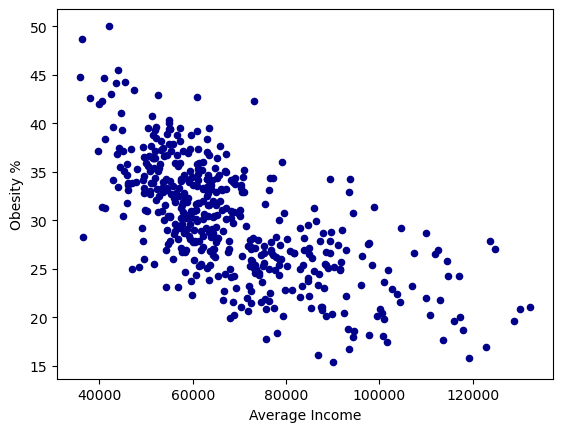

In [13]:
# Quick plot to look at all cities obesity as a function of income
ax1 = final_merge_df.plot.scatter(x='Average Income',
                      y='Obesity %',
                      c='DarkBlue')

In [14]:
# Review Weather df
weather_df.head(5)


,City,Avg_High_Temp_F,Avg_Low_Temp_F
0,"Atlanta, Georgia",73,54
1,"Austin, Texas",81,59
2,"Baltimore, Maryland",67,46
3,"Birmingham, Alabama",74,54
4,"Boston, Massachusetts",59,45


In [15]:
# need to make City format the same as final df so that we can merge df's
#split city column into two 
weather_df[['City_reformat', 'State']] = weather_df['City'].str.split(',',expand=True)


weather_df.head()

,City,Avg_High_Temp_F,Avg_Low_Temp_F,City_reformat,State
0,"Atlanta, Georgia",73,54,Atlanta,Georgia
1,"Austin, Texas",81,59,Austin,Texas
2,"Baltimore, Maryland",67,46,Baltimore,Maryland
3,"Birmingham, Alabama",74,54,Birmingham,Alabama
4,"Boston, Massachusetts",59,45,Boston,Massachusetts


In [17]:
#drop State and city columns axis=1)
#df.drop(columns=['B', 'C']) or df.drop(['B', 'C'], axis=1)
weather_df= weather_df.drop(['City', 'State'], axis=1)

weather_df.head()

,Avg_High_Temp_F,Avg_Low_Temp_F,City_reformat
0,73,54,Atlanta
1,81,59,Austin
2,67,46,Baltimore
3,74,54,Birmingham
4,59,45,Boston


In [19]:
#rename City_reformat column so we can merge with final df 
weather_df = weather_df.rename(columns={"City_reformat": 'City'})
weather_df.head()

,Avg_High_Temp_F,Avg_Low_Temp_F,City
0,73,54,Atlanta
1,81,59,Austin
2,67,46,Baltimore
3,74,54,Birmingham
4,59,45,Boston


In [22]:
#inner merge of weather and final_merge_df dataset
# FINAL WEATHER DF

final_wea_merged_df = pd.merge(final_merge_df, weather_df, left_on='City', right_on='City', how='inner')
#wea_merged_df = wea_merged_df.drop(['City','State'], axis=1)
#wea_merged_df = wea_merged_df.rename(columns={"CityName": "City", "Data_Value": "Obesity %", "Mean": 'Average Income'})
final_wea_merged_df.head()

,City,Lat,Lon,Average Income,Obesity %,Avg_High_Temp_F,Avg_Low_Temp_F
0,Atlanta,33.763066,-84.404890,75563.546875,31.640152,73,54
1,Austin,30.303714,-97.750737,78442.658824,25.993000,81,59
2,Baltimore,39.310760,-76.618262,63393.091549,39.562189,67,46
3,Birmingham,33.526924,-86.794535,54848.358974,40.329348,74,54
4,Boston,42.325134,-71.087434,78451.611111,25.387429,59,45


In [21]:
#Raghen Weater Data Analysis Start Here

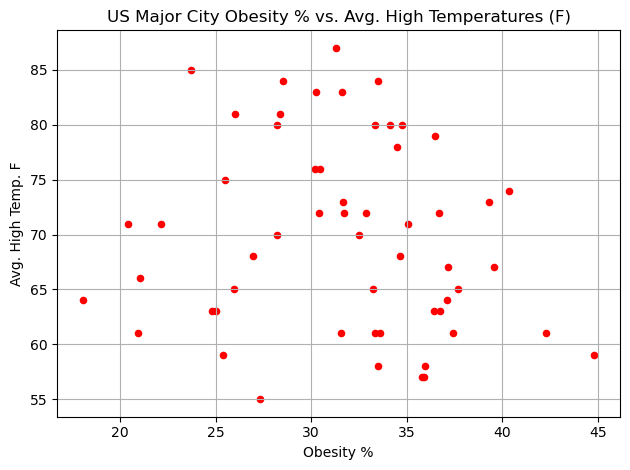

In [31]:
# Scatter plot to look at all major US cities obesity as a function of High Temp
High_Temp_plot = final_wea_merged_df.plot.scatter(x='Obesity %',
                      y='Avg_High_Temp_F',
                      c='Red')
# Incorporate the other graph properties
plt.grid()
plt.xlabel("Obesity %")
plt.ylabel("Avg. High Temp. F")
plt.title("US Major City Obesity % vs. Avg. High Temperatures (F)")
plt.tight_layout()

# Save the figure
plt.savefig("output_data/Fig1_Obesity_vs_HighTemp.png")

# Show plot
plt.show()

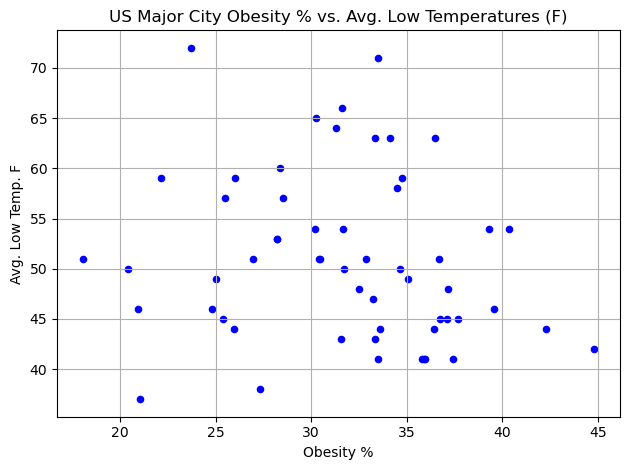

In [33]:
# Scatter plot to look at all major US cities obesity as a function of Low Temp
Low_Temp_plot = final_wea_merged_df.plot.scatter(x='Obesity %',
                      y='Avg_Low_Temp_F',
                      c='Blue')

# Incorporate the other graph properties
plt.grid()
plt.xlabel("Obesity %")
plt.ylabel("Avg. Low Temp. F")
plt.title("US Major City Obesity % vs. Avg. Low Temperatures (F)")
plt.tight_layout()

# Save the figure
plt.savefig("output_data/Fig2_Obesity_vs_LowTemp.png")

# Show plot
plt.show()

Linear equation: y = -0.19x + 76.04
The r-value is: -0.12976571349111132


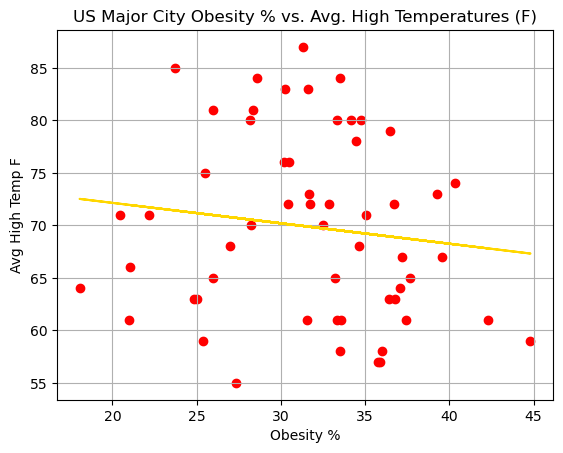

In [39]:
# Linear regression on High and Low Avg Temps 
# Define a function to create Linear Regression plots
plt.scatter(final_wea_merged_df['Obesity %'],final_wea_merged_df['Avg_High_Temp_F'], marker='o', facecolors='red', edgecolors='red')


# Incorporate the other graph properties
plt.grid()
plt.xlabel("Obesity %")
plt.ylabel("Avg High Temp F")
plt.title("US Major City Obesity % vs. Avg. High Temperatures (F)")

# Create Linear Regression plots
def lr_funcV2(x,y,name,vbl,hemi):
    (slope,intercept,rvalue,pvalue,stderror)=linregress(x,y)
    reg_values= x*slope + intercept
    plt.plot(x,reg_values,color='gold')
    #plt.title(f'Latitude vs. {vbl} - {hemi}')
    plt.xlabel('Obesity %')
    #plt.ylabel(vbl)
    line_eq = f'y = {(round(slope,2))}x + {(round(intercept,2))}'
    print(f'Linear equation: {line_eq}')
    plt.savefig(f"output_data/LinearRegresion_{name}.png")
    print(f'The r-value is: {rvalue}')

x = final_wea_merged_df['Obesity %']
y = final_wea_merged_df['Avg_High_Temp_F']
name = 'Obesity_VS_Avg_High_Temp'
vbl = 'Obesity %'
hemi = 'Northern Hemisphere'
lr_funcV2(x,y,name,vbl,hemi)
plt.show()